In [2]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

## Data Generation Process

In [4]:
# Dataset parameters
treatment = "treatment"
targets = ["outcome"]
instruments = ["instrument"]
outcome = targets[0]

In [33]:
# Timo's Synthetic Datasets
from typing import Union

def generate_psdmat(n_dims: int = 10) -> np.ndarray:
    """generates a symmetric, positive semidefinite matrix

    Args:
        n_dims (int, optional): number of dimensions. Defaults to 10.

    Returns:
        np.ndarray: psd matrix
    """
    A = np.random.rand(n_dims, n_dims)
    A = A@A.T
    
    return A


def mu_zero(X:np.ndarray) -> np.ndarray:
    """hard-coded transformation of covariates, including interaction terms

    Args:
        X (np.ndarray): matrix of n observations and d covariates

    Returns:
        np.ndarray: transformed matrix
    """
    return X[:,0] * X[:,1] + X[:,2] + X[:,3] * X[:,4]

def generate_iv_data(
    n_samples: int = 100,
    n_covariates: int = 5,
    covariance: Union[str, np.ndarray] = "isotropic",
    confounding: bool = True,    
    noisy_outcomes: bool = False,
    effect_size: int = 5,

) -> pd.DataFrame:
    """generates synthetic dataset with constant treatment effect (ATE) and instrumental variable

    Args:
        n_samples (int, optional): number of independent samples. Defaults to 100.
        n_covariates (int, optional): number of covariates. Defaults to 5.
        covariance (Union[str, np.ndarray], optional): covariance matrix of covariates. can be "isotropic", "anisotropic" or user-supplied. Defaults to "isotropic".
        confounding (bool, optional): whether or not values of covariates affect treatment effect. Defaults to True.        
        noisy_outcomes (bool, optional): additive noise in the outcomes. Defaults to False.

    Returns:
        pd.DataFrame: columns for covariates, treatment assignment, outcome and true treatment effect
    """

    if covariance == "isotropic":
        sigma = np.random.randn(1)
        covmat = np.eye(n_covariates)*sigma**2
    elif covariance == "anisotropic":
        covmat = generate_psdmat(n_covariates)

    X = np.random.multivariate_normal(mean=[0]*n_covariates,cov=covmat,size=n_samples)

    Z = np.random.binomial(n=1,p=0.5, size=n_samples)
    if confounding:
        C = 1/(1+np.exp(X[:,0]*X[:,1]+X[:,2]*3)) > np.random.rand(n_samples)
    else:
        C = np.random.binomial(n=1, p=0.5,size=n_samples)

    C0 = np.random.binomial(n=1, p=0.006, size=n_samples)

    T = C*Z + C0*(1-Z)
    # fixed effect size:    
    tau = effect_size

    err = np.random.randn(n_samples) *0.05 if noisy_outcomes else 0

    Y = tau*T + mu_zero(X) + err

    df = pd.DataFrame(np.array([*X.T,T,Y,Z,[tau]*n_samples]).T,columns=[f"X{i}" for i in range(1,n_covariates+1)]+["treatment","outcome","instrument","true_effect"])
    return df

### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by the auto-causality tool for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [36]:
# Preprocess data
data = generate_iv_data(n_samples=5000,confounding=True)

TRUE_EFFECT = data.true_effect.mean()

data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.33, random_state=123)

Xtest_constant_te = test_df[features_X]

In [37]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"]

ac_constant_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    # time_budget=1200,
    components_time_budget=30,
    propensity_model="auto",
    train_size=0.5
)

ac_constant_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-20 09:31:35] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-20 09:31:35] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-20 09:31:38] {118} INFO - result: {'energy_distance': 0.003059763002886129, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x2a5b5aeb0>, 'ate': 4.967141628265381, 'ate_std': 0.0, 'energy_distance': 0.003424269219290954}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x2a5b67f10>, 'ate': 4.967141628265381, 'ate_std': 0.0, 'energy_distance': 0.003059763002886129}}, 'config

In [40]:
get_est_effects(ac_constant_te, Xtest_constant_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,4.967142,6.415372
1,iv.econml.iv.dml.DMLIV,2.027874,29.944163
2,iv.econml.iv.dml.OrthoIV,4.984444,6.328024
3,iv.econml.iv.dr.IntentToTreatDRIV,4.505154,8.969103
4,iv.econml.iv.dr.LinearDRIV,2.496139,25.038625


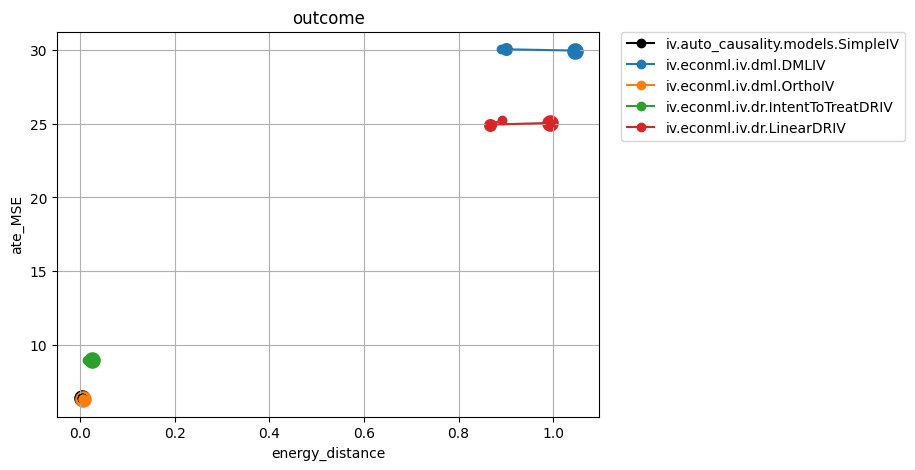

In [41]:
score_all_test(ac_constant_te, test_df)
graph_compare_estimators(ac_constant_te)

In [6]:
# score all estimators on the test set
def score_all_test(models, test_set):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            # print(causal_estimate.estimator._treatment_name)
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate,
                test_set,
                problem=models.problem,
                metrics_to_report=models.metrics_to_report
            )
        except Exception as e:
            print(e)
            pass


def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [7]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_scores.append([est_name, est_effect, (est_effect-te)**2])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse"])


In [8]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()
